In [23]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas
import tensorflow as tf
import time
import datetime
import os
import csv
import random

In [24]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

#os.environ["CUDA_VISIBLE_DEVICES"]="-1"   

1 Physical GPUs, 1 Logical GPUs


In [25]:
class stock_dataset():
    headers = 'Datetime,Open,High,Low,Close,Volume,Dividends,Stock Splits'
    datetime_stock = list()
    open_price = list()
    high_price = list()
    low_price = list()
    close_price = list()
    volume_stock = list()
    
    dividends = list()
    stock_splits = list()
    
#     folder_dir = 'stock_history/hk/0005.hk/'
    folder_dir = 'stock_history/hk/0005.hk/'
    files=os.listdir(folder_dir)
    files.sort()
    print(files)
    
    
    for file in files:
        try:
            with open(folder_dir+file, newline='') as csvfile:
                rows = csv.reader(csvfile)
                first_row = True
                first_data = True
                cache_value = 0
                for row in rows:
                    if first_row:
                        first_row = False
                        continue
                    if not first_row:
#                         print(row)
                        datetime_stock.append(row[0])
                        open_price.append(float(row[1]))
                        high_price.append(float(row[2]))
                        low_price.append(float(row[3]))
                        close_price.append(float(row[4]))
                    
    #         Datetime.append()
        except:
            print('The file "' + file + '" is not a csv file.')


['.ipynb_checkpoints', '2020-12-01.csv', '2020-12-02.csv', '2020-12-03.csv', '2020-12-04.csv', '2020-12-05.csv', '2020-12-06.csv', '2020-12-07.csv', '2020-12-08.csv', '2020-12-09.csv', '2020-12-10.csv', '2020-12-11.csv', '2020-12-12.csv', '2020-12-13.csv', '2020-12-14.csv', '2020-12-15.csv', '2020-12-16.csv', '2020-12-17.csv', '2020-12-18.csv', '2020-12-19.csv', '2020-12-20.csv', '2020-12-21.csv', '2020-12-22.csv', '2020-12-23.csv', '2020-12-24.csv', '2020-12-25.csv', '2020-12-26.csv', '2020-12-27.csv', '2020-12-28.csv', '2020-12-29.csv', '2020-12-30.csv', '2020-12-31.csv']
The file ".ipynb_checkpoints" is not a csv file.


In [26]:
# print(stock_dataset.close_price)
time = range(0, len(stock_dataset.close_price))
price_instance = stock_dataset.close_price
series = np.array(price_instance)


split_time_train = int(0.8*len(stock_dataset.close_price))
split_time_val = int(0.95*len(stock_dataset.close_price))

time_train = time[:split_time_train]
x_train = series[:split_time_train]
print(x_train.shape)
time_valid = time[split_time_train:split_time_val]
x_valid = series[split_time_train:split_time_val]

time_test = time[split_time_val:]
x_test = series[split_time_val:]

window_size = 10
batch_size = len(price_instance)
shuffle_buffer_size = 1000

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Number of cases")
    plt.grid(True)

def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

# window_size = 20
# batch_size = 240

train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
val_set = windowed_dataset(x_valid, window_size, batch_size, shuffle_buffer_size)
test_set = windowed_dataset(x_test, window_size, batch_size, shuffle_buffer_size)
print(train_set)
# print(x_train.shape)
#relu
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.LSTM(512, return_sequences=True),
    tf.keras.layers.LSTM(256, return_sequences=True),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 50) #400
])

# lr_schedule = tf.keras.callbacks.LearningRateScheduler(
#     lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])


(5496,)
<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>


In [ ]:
# Create a callback that saves the model's weights every 5 epochs
checkpoint_path='checkpoint/cp-{epoch:04d}.h5'

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1,
    save_weights_only=False,
    save_freq=50)


history = model.fit(train_set, validation_data=val_set, epochs=10000, callbacks=[cp_callback]) #, callbacks=[lr_schedule]
model.save('test_model.h5')

# plt.semilogx(history.history["lr"], history.history["loss"])
# plt.axis([1e-8, 1e-4, 0, 60])
# plt.show()


Epoch 1/10000
1/1 [==============================] - 6s 6s/step - loss: 41.2972 - mae: 41.7972 - val_loss: 38.9050 - val_mae: 39.4050
Epoch 2/10000
1/1 [==============================] - 2s 2s/step - loss: 41.1044 - mae: 41.6044 - val_loss: 38.5150 - val_mae: 39.0150
Epoch 3/10000
1/1 [==============================] - 2s 2s/step - loss: 40.7921 - mae: 41.2921 - val_loss: 37.9583 - val_mae: 38.4583
Epoch 4/10000
1/1 [==============================] - 2s 2s/step - loss: 40.3337 - mae: 40.8337 - val_loss: 37.2537 - val_mae: 37.7537
Epoch 5/10000
1/1 [==============================] - 2s 2s/step - loss: 39.7626 - mae: 40.2626 - val_loss: 36.4119 - val_mae: 36.9119
Epoch 6/10000
1/1 [==============================] - 2s 2s/step - loss: 39.0678 - mae: 39.5678 - val_loss: 35.4530 - val_mae: 35.9530
Epoch 7/10000
1/1 [==============================] - 2s 2s/step - loss: 38.3160 - mae: 38.8160 - val_loss: 34.4083 - val_mae: 34.9083
Epoch 8/10000
1/1 [==============================] - 2s 2s/ste

Epoch 1537/10000
1/1 [==============================] - 2s 2s/step - loss: 0.5718 - mae: 0.9499 - val_loss: 0.8423 - val_mae: 1.3386
Epoch 1538/10000
1/1 [==============================] - 2s 2s/step - loss: 0.5702 - mae: 0.9479 - val_loss: 0.8426 - val_mae: 1.3389
Epoch 1539/10000
1/1 [==============================] - 2s 2s/step - loss: 0.5715 - mae: 0.9496 - val_loss: 0.8429 - val_mae: 1.3392
Epoch 1540/10000
1/1 [==============================] - 2s 2s/step - loss: 0.5720 - mae: 0.9496 - val_loss: 0.8432 - val_mae: 1.3394
Epoch 1541/10000
1/1 [==============================] - 1s 1s/step - loss: 0.5705 - mae: 0.9476 - val_loss: 0.8435 - val_mae: 1.3398
Epoch 1542/10000
1/1 [==============================] - 2s 2s/step - loss: 0.5720 - mae: 0.9496 - val_loss: 0.8438 - val_mae: 1.3401
Epoch 1543/10000
1/1 [==============================] - 2s 2s/step - loss: 0.5711 - mae: 0.9487 - val_loss: 0.8439 - val_mae: 1.3403
Epoch 1544/10000
1/1 [==============================] - 2s 2s/step - 

In [5]:
cut_off = 1000

loss = history.history['loss']
loss = loss[cut_off:]
mae = history.history['mae']
mae = mae[cut_off:]
val_loss = history.history['val_loss']
val_loss = val_loss[cut_off:]
val_mae = history.history['val_mae']
val_mae = val_mae[cut_off:]

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()

NameError: name 'history' is not defined

2.4.0
6871
6871


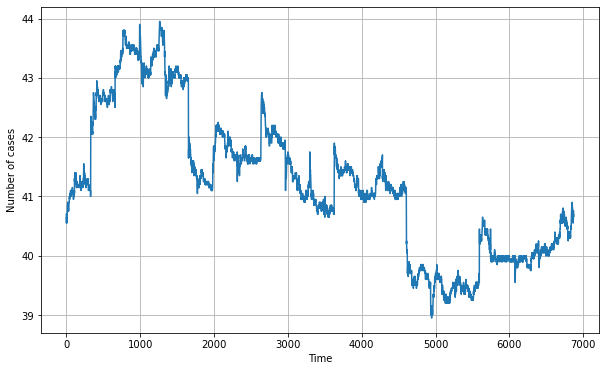

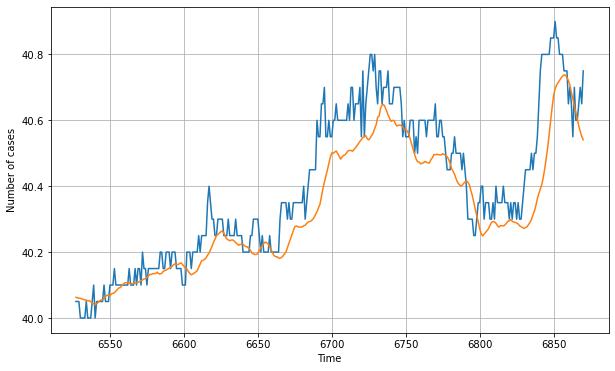

6871


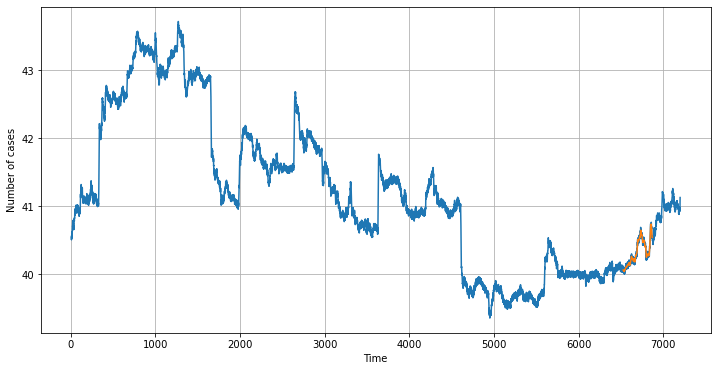

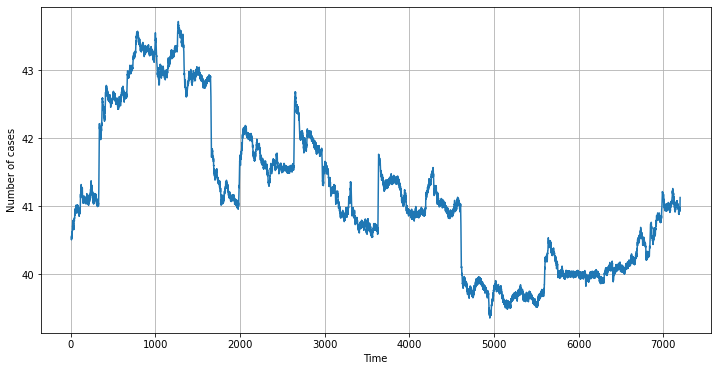

In [32]:
plt.figure(figsize=(10, 6))
raw_data = np.array(price_instance[0:])
raw_days = range(0,len(raw_data))

plot_series(raw_days, raw_data)

# plt.show()

print(tf.__version__)
datas_prediction = []
print(len(price_instance))
series_prediction = np.array([])
model = tf.keras.models.load_model('test_model.h5')
datas_prediction = np.array(price_instance)

print(len(price_instance))
forward_day = len(price_instance)-10
prediction_days = 330 + forward_day



rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time_val - window_size:-1, -1, 0]

# print(tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy())

plt.figure(figsize=(10, 6))
plot_series(time_test, x_test)
plot_series(time_test, rnn_forecast)
plt.show()


for i in range(prediction_days):
#     print(len(datas_prediction))
    # print(type(datas[333]))
    # print(type(model.predict(series[len(datas)-5:len(datas),np.newaxis][np.newaxis])[0,-1,0]))
    series_prediction = np.array(datas_prediction)
    noise = random.randrange(-100,100) * 0.0005
    datas_prediction = np.append(datas_prediction, float(model.predict(series_prediction[len(datas_prediction)-window_size-forward_day:len(datas_prediction)-forward_day,np.newaxis][np.newaxis])[0,-1,0]+noise))
#     print(model.predict(series_prediction[len(datas_prediction)-window_size:len(datas_prediction),np.newaxis][np.newaxis])[0,-1,0])
print(len(price_instance))
time_test_prediction = range(len(price_instance)-forward_day,len(price_instance)+prediction_days-forward_day)
x_test_prediction = datas_prediction[len(datas_prediction)-prediction_days:len(datas_prediction)]

plt.figure(figsize=(12, 6))
plot_series(time_test_prediction, x_test_prediction)
plot_series(time_test, rnn_forecast)
plt.show()

plt.figure(figsize=(12, 6))
plot_series(time_test_prediction, x_test_prediction)
plt.show()